In [1]:
import os
from glob import glob 
import time
import numpy as np  # for math operations, one of the most commonly used libraries
import pandas as pd  # for handling data and data frames, another essential library
import cv2  # OpenCV library, which we will use to "read" images and transform them
import matplotlib.pyplot as plt  # to visualize data
from tqdm.notebook import tqdm # to see the progress
import gc #garbage collection to save RAM

# the output of plotting commands is displayed inline within Jupyter notebook:
%matplotlib inline  

from sklearn.model_selection import train_test_split as tts # to split train and validation data
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# PyTorch libraries to build a Machine Learning Model:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset


In [2]:
data_train_path = "../input/histopathologic-cancer-detection/train"
data_test_path = "../input/histopathologic-cancer-detection/test"
data_train_labels = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

In [3]:
df = pd.DataFrame({'path': glob(os.path.join(data_train_path,'*.tif'))}) # load the filenames
# df['path'][0]
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) # keep only the file names in 'id'
# df['id'][0]
print(df.head(5))
df = df.merge(data_train_labels, on = "id") # merge labels and filepaths
df.head(10)

                                                path  \
0  ../input/histopathologic-cancer-detection/trai...   
1  ../input/histopathologic-cancer-detection/trai...   
2  ../input/histopathologic-cancer-detection/trai...   
3  ../input/histopathologic-cancer-detection/trai...   
4  ../input/histopathologic-cancer-detection/trai...   

                                         id  
0  d43c081bafa286f9c1f7e921883f26ceafebc912  
1  092d0eedebce504847715ee046b6ad74b57599b4  
2  b0d2582c6218a8764323fc940b41312282b99bf4  
3  187c99df762f13f99818e5593d4bab4c6577e7e3  
4  7c5270c83837de5a5cbb2dca511559dc39d19d53  


,path,id,label
0,../input/histopathologic-cancer-detection/trai...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/histopathologic-cancer-detection/trai...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,../input/histopathologic-cancer-detection/trai...,b0d2582c6218a8764323fc940b41312282b99bf4,0
3,../input/histopathologic-cancer-detection/trai...,187c99df762f13f99818e5593d4bab4c6577e7e3,1
4,../input/histopathologic-cancer-detection/trai...,7c5270c83837de5a5cbb2dca511559dc39d19d53,1
5,../input/histopathologic-cancer-detection/trai...,5a32933e093185f5fc91d30fc83ad571c6818d25,1
6,../input/histopathologic-cancer-detection/trai...,42e77d193e73811e0bb65a0cbd9b01c5c27900fa,0
7,../input/histopathologic-cancer-detection/trai...,27bb898f54a0b9345f6c4a9083299e4465860861,0
8,../input/histopathologic-cancer-detection/trai...,89cd55e4300440612347c38f306da688a166fd40,0
9,../input/histopathologic-cancer-detection/trai...,cd600f77aa2af7c93dc6cd836e44edada3d8c403,0


In [4]:
def load_data(N, df):
    """ This function loads N images using the data df """
    # Allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N, 96, 96, 3], dtype=np.uint8)

    # Convert the labels to a numpy array too
    y = np.squeeze(df['label'].values)[0:N]  # Corrected the line

    # Read images one by one, tqdm notebook displays a progress bar
    for i, row in tqdm(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])

    return X, y


In [5]:
# say n=10000
N = 1000
x,y = load_data(N,df)
print(len(x))
print(len(y))


  0%|          | 0/1000 [00:00<?, ?it/s]

1000
1000


In [6]:
x = x / 255.0  # Normalize pixel values


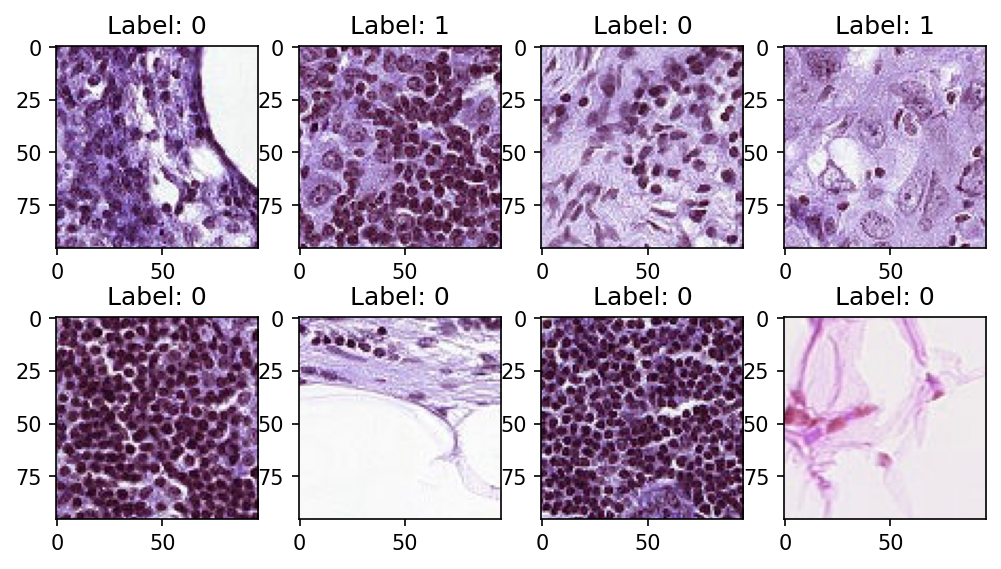

In [7]:
fig = plt.figure(figsize=(8, 9), dpi=150)
np.random.seed(100) #we can use the seed to get a different set of random images
image_count = 8  # number of images we want to have

# iterate over a list of random numbers, then plot images with labels
for plot_idx, image_idx in enumerate(np.random.randint(0, N, image_count)):
    ax = fig.add_subplot(4, 4, plot_idx+1)
    plt.imshow(x[image_idx])
    ax.set_title("Label: " + str(y[image_idx]))


Text(0, 0.5, '# of samples')

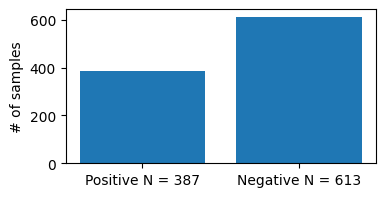

In [8]:
fig = plt.figure(figsize=(4, 2),dpi=100)
#plot bars of numbers of positive and negative samples
number_of_negatives = (y==0).sum()
number_of_positives = (y==1).sum()
negative_samples = x[y==0]
positive_samples = x[y==1]
plt.bar([1, 0], [number_of_negatives, number_of_positives])
plt.xticks([1, 0], ["Negative N = " + str(number_of_negatives), 
                    "Positive N = " + str(number_of_positives)])
plt.ylabel("# of samples")
# len(positive_samples)

Text(0.5, 1.0, 'Negative Samples')

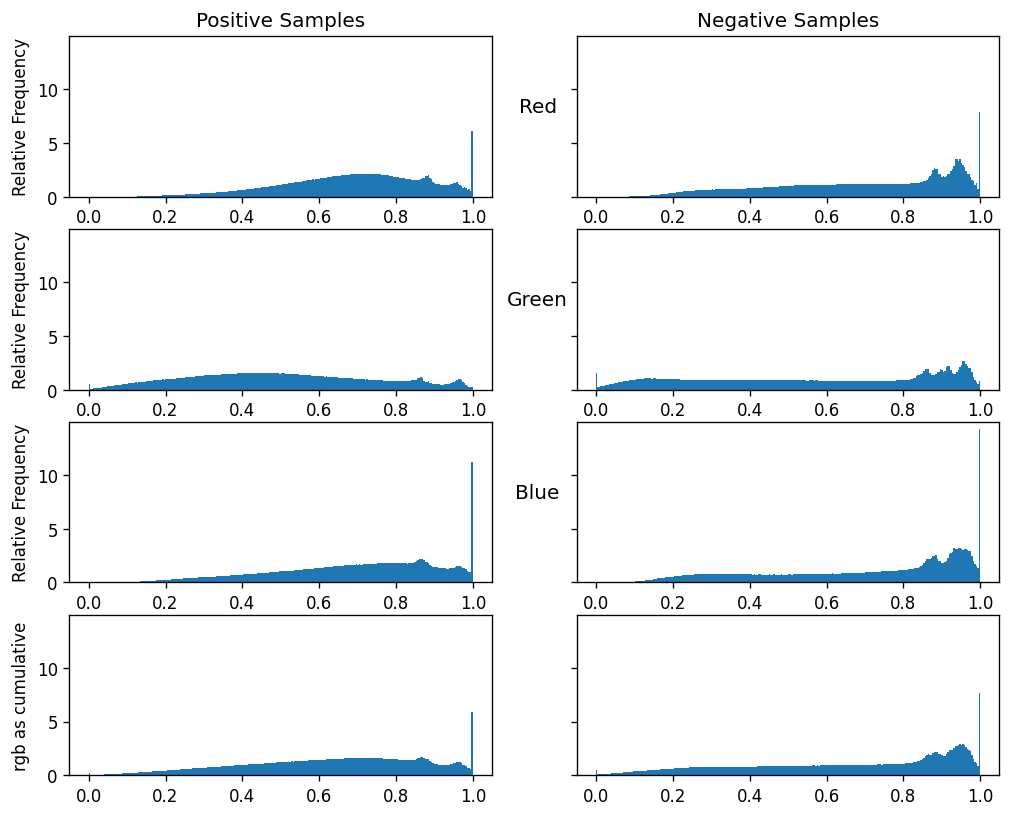

In [9]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(10,8),dpi=120)  # 4 by 2 plot
rgb_list = ["Red", "Green", "Blue", "RGB"]

#append a histogram to each of the 4*2=8 positions of the axs
for row_idx in range(0, 4):
    for col_idx in range(0, 2):
        if row_idx < 3:
            axs[row_idx, 0].set_ylabel("Relative Frequency")
            axs[row_idx, 1].set_ylabel(rgb_list[row_idx], rotation="horizontal",
                                       labelpad=20, fontsize=12)
            # show the color channels
            if col_idx == 0: #show positive samples
                axs[row_idx, 0].hist(positive_samples[:, :, :, row_idx].flatten(),
                                     bins=nr_of_bins, density = True)
            elif col_idx == 1: #show negative sampels
                axs[row_idx, 1].hist(negative_samples[:, :, :, row_idx].flatten(),
                                     bins=nr_of_bins, density = True)
                
        else:
            # show the rgb as cumulative
            if col_idx == 0: #show positive samples
                axs[row_idx, 0].set_ylabel("rgb as cumulative")
                axs[row_idx, 0].hist(positive_samples.flatten(),
                                     bins=nr_of_bins, density = True)
            elif col_idx == 1: #show negative sampels
                axs[row_idx, 1].hist(negative_samples.flatten(),
                                     bins=nr_of_bins, density = True)
                
axs[0, 0].set_title("Positive Samples")
axs[0, 1].set_title("Negative Samples")


In [10]:
from sklearn.decomposition import PCA
# pca = PCA()
# flattened_images = x.reshape(x.shape[0], -1)
# pca.fit(flattened_images)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.show()
# print(pca.explained_variance_ratio_.sum())
def pca_visualization(images, labels, n_components=10):
    pca = PCA(n_components=n_components)
    flattened_images = images.reshape(images.shape[0], -1)
    pca_result = pca.fit_transform(flattened_images)
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[labels == 0, 0], pca_result[labels == 0, 1], label='Negative', alpha=0.5)
    plt.scatter(pca_result[labels == 1, 0], pca_result[labels == 1, 1], label='Positive', alpha=0.5)
    plt.title('PCA Visualization')
    plt.legend()
    plt.show()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()
    print(pca.explained_variance_ratio_.sum())


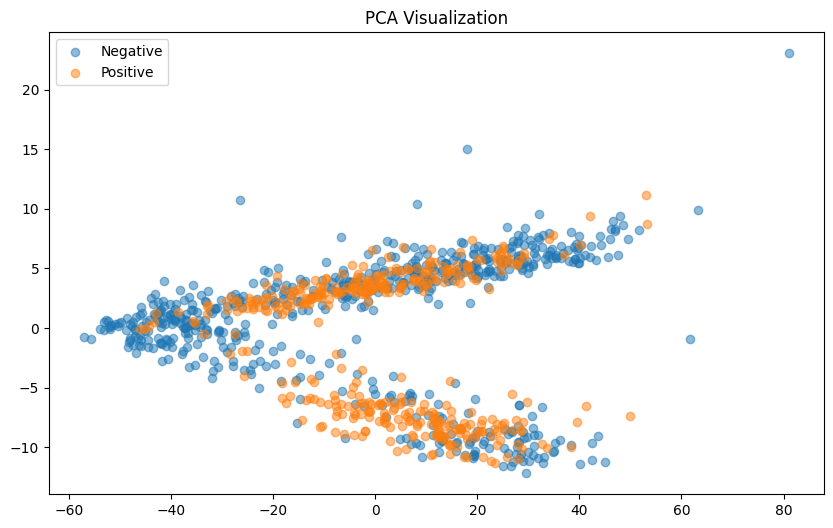

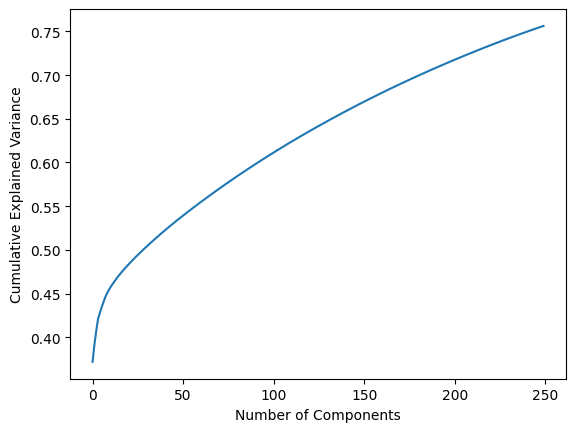

0.7563396348208092


In [11]:
pca_visualization(x,y,n_components=250)


In [12]:
x_train,x_temp,y_train,y_temp = tts(x,y,test_size = 0.3 ,shuffle =True ,stratify=y)
x_train.shape
x_val,x_test,y_val,y_test = tts(x_temp,y_temp,test_size = 0.33 ,shuffle =True ,stratify=y_temp)
x_train.shape


(700, 96, 96, 3)

# CNN

In [13]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 32 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [14]:
model_cnn = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)


In [15]:
x_train_tensor = torch.Tensor(x_train).permute(0, 3, 1, 2)
y_train_tensor = torch.Tensor(y_train.reshape(-1, 1))


In [16]:
for epoch in range(10):  # Adjust the number of epochs
    model_cnn.train()
    optimizer.zero_grad()
    outputs = model_cnn(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()


In [17]:
model_cnn.eval()
x_test_tensor = torch.Tensor(x_test).permute(0, 3, 1, 2)
y_test_tensor = torch.Tensor(y_test.reshape(-1, 1))


In [18]:
with torch.no_grad():
    y_pred_cnn = model_cnn(x_test_tensor)
    y_pred_cnn = torch.sigmoid(y_pred_cnn).numpy()

accuracy_cnn = accuracy_score(y_test, y_pred_cnn > 0.5)
precision_cnn = precision_score(y_test, y_pred_cnn > 0.5)
recall_cnn = recall_score(y_test, y_pred_cnn > 0.5)
f1_score_cnn = f1_score(y_test, y_pred_cnn > 0.5)
confusion_matrix_cnn = confusion_matrix(y_test, y_pred_cnn > 0.5)


In [19]:
print("CNN Model Metrics:")
print("Accuracy:", accuracy_cnn)
print("Precision:", precision_cnn)
print("Recall:", recall_cnn)
print("F1 Score:", f1_score_cnn)
print("Confusion Matrix:")
print(confusion_matrix_cnn)


CNN Model Metrics:
Accuracy: 0.6161616161616161
Precision: 0.5
Recall: 0.23684210526315788
F1 Score: 0.32142857142857145
Confusion Matrix:
[[52  9]
 [29  9]]


# Random Forest

In [20]:
x_train_rf = x_train.reshape(x_train.shape[0], -1)
x_test_rf = x_test.reshape(x_test.shape[0], -1)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=64)
rf_classifier.fit(x_train_rf, y_train)


RandomForestClassifier(random_state=64)

In [21]:
y_pred_rf = rf_classifier.predict(x_test_rf)


In [22]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_score_rf = f1_score(y_test, y_pred_rf)
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)


In [23]:
print("Random Forest Model Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_score_rf)
print("Confusion Matrix:")
print(confusion_matrix_rf)


Random Forest Model Metrics:
Accuracy: 0.7575757575757576
Precision: 0.75
Recall: 0.5526315789473685
F1 Score: 0.6363636363636364
Confusion Matrix:
[[54  7]
 [17 21]]


# SVM

In [24]:
# prex_train = X/255.0
flattened_images = [image.flatten() for image in x_train]
X_train_flat = np.vstack(flattened_images)
flattened_images = [image.flatten() for image in x_val]
X_test_flat = np.vstack(flattened_images)

In [26]:
clf = svm.SVC(kernel='rbf', class_weight = 'balanced')
clf.fit(X_train_flat, y_train)

y_pred_svm = clf.predict(X_test_flat)
accuracy = accuracy_score(np.array(y_val), y_pred_svm)
print(accuracy)

0.7860696517412935


In [28]:
accuracy_svm = accuracy_score(y_val, y_pred_svm)
precision_svm = precision_score(y_val, y_pred_svm)
recall_svm = recall_score(y_val, y_pred_svm)
f1_score_svm = f1_score(y_val, y_pred_svm)
confusion_matrix_svm = confusion_matrix(y_val, y_pred_svm)


In [31]:
print("Random Forest Model Metrics:")
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1 Score:", f1_score_svm)
print("Confusion Matrix:")
print(confusion_matrix_svm)

Random Forest Model Metrics:
Accuracy: 0.7860696517412935
Precision: 0.7160493827160493
Recall: 0.7435897435897436
F1 Score: 0.7295597484276728
Confusion Matrix:
[[100  23]
 [ 20  58]]


# COMPARISON

In [29]:
# Data for plotting
models = ['Random Forest', 'CNN', 'SVM']
accuracies = [accuracy_rf, accuracy_cnn, accuracy_svm]
precisions = [precision_rf, precision_cnn, precision_svm]


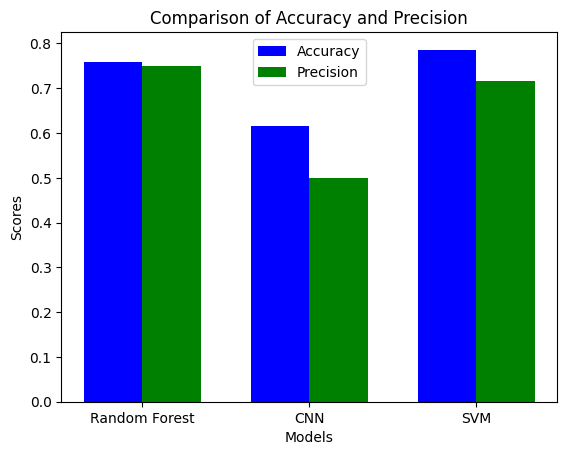

In [30]:
# Create a groupedabar plot
fig, ax = plt.subplots()

bar_width = 0.35
index = range(len(models))

# Plot accuracy
bar1 = ax.bar(index, accuracies, bar_width, label='Accuracy', color='b')

# Plot precision
bar2 = ax.bar([i + bar_width for i in index], precisions, bar_width, label='Precision', color='g')

# Set labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Accuracy and Precision')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(models)
ax.legend()

plt.show()
